In [1]:
import numpy as np
from astropy import constants as const
from astropy.time import Time
import astropy.units as u
from numpy import sin, cos, tan, sqrt, arctan, pi
import matplotlib.pyplot as plt

In [19]:
#Punto 1 y 2


# Constantes
G=const.G
G=G.to(u.km**3/(u.s**2*u.kg))
M=const.M_earth
GM = G*M
e = 0.1656  # Excentricidad
w = (15 * u.deg).to(u.rad)  # Argumento del perihelio (en radianes)
a = (1.30262 * const.R_earth).to(u.km)  # Semieje mayor
# Tiempo tp
tp = Time('2025-03-31T00:00:00', scale='utc', format='isot')

# Ecuación de Kepler
def keplereq(E, l, e):
    return E - e * np.sin(E*u.rad) - l.value

def derivada_kepler(E, e):
    return 1 - e * np.cos(E*u.rad)

def metodo_newton(e, l, tolerancia=1e-6,iteraciones=100):
    """Resuelve la ecuación de Kepler usando el método de Newton-Raphson."""
    E = 0 #E0

    for iteracion in range(iteraciones):
        f_E = keplereq(E, l, e)  # Función de Kepler
        f_prime_E = derivada_kepler(E, e)  # Derivada de la función

        E_new = E - f_E / f_prime_E  # Nueva aproximación

        # Verificar convergencia
        if abs(E_new - E) < tolerancia:
            return E_new

        E = E_new

    # Si no se alcanza la convergencia, devolver el último valor
    print("No se alcanzó la convergencia.")
    return E

# Función para calcular r y phi
def position(ti):
    ti = Time(ti, scale='utc', format='isot')
    t = (ti - tp).to(u.s)  # Tiempo transcurrido en segundos
    l = np.sqrt(GM / a**3) * t  # Anomalía media en radianes

    # Resolver ecuación de Kepler
    E_sol = metodo_newton(e, l)*u.rad

    # Calcular f
    f = 2 * arctan(sqrt((1 + e) / (1 - e)) * tan(E_sol / 2))

    # Calcular distancia r y ángulo phi
    r = a * (1 - e * cos(E_sol))
    phi = f + w

    return r.to(u.km), phi.to(u.deg)


#Tiempo donde se quiere conocer r y phi:
t= Time('2025-04-01T00:00:00', scale='utc', format='isot')

r, phi = position(t)

print(f"r = {r}, phi = {phi}")

r = 9658.326350394309 km, phi = 185.59638082331438 deg


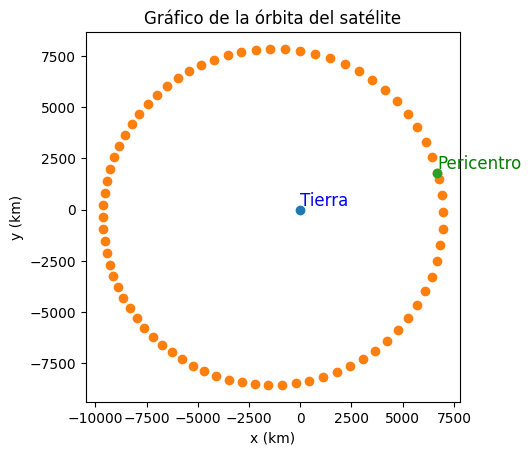

In [24]:
#Punto 3


def orbit():
    # Definir el tiempo de inicio y fin
    periodo = 2 * np.pi * np.sqrt(a**3 / GM)
    tiempo_inicial = Time('2025-03-31T00:00:00', scale='utc', format='isot')  # Tiempo de inicio
    tiempo_final = tiempo_inicial + periodo  # Tiempo de fin

    # Convertir los tiempos a segundos para calcular el número de pasos
    pasos_de_tiempo = 100  # Paso de tiempo en segundos

    # Calcular el número total de pasos en segundos
    numero_de_pasos = int((tiempo_final - tiempo_inicial).to(u.s).value / pasos_de_tiempo)

    # Inicializar arrays de NumPy con el tamaño adecuado
    rval = np.zeros(numero_de_pasos + 1)  # Creamos un array de ceros de tamaño numero_de_pasos + 1
    phival = np.zeros(numero_de_pasos + 1)

    # Iterar sobre el rango de tiempos usando un bucle for
    tiempo_actual = tiempo_inicial
    for i in range(numero_de_pasos + 1):  # +1 para incluir el último tiempo
        r, phi = position(tiempo_actual)

        # Asignar los valores de r y phi al array
        rval[i] = r.value
        phival[i] = phi.value

        # Incrementar el tiempo en un paso (en segundos)
        tiempo_actual += pasos_de_tiempo * u.s

    # Crear la gráfica
    plt.scatter(0,0)
    plt.text(0, 0, 'Tierra', fontsize=12, ha='left', va='bottom', color='blue')
    plt.scatter(rval * np.cos(phival * u.deg.to(u.rad)), rval * np.sin(phival * u.deg.to(u.rad)))
    plt.xlabel("x (km)")
    plt.ylabel("y (km)")
    plt.title("Órbita del satélite")

    # Resaltar la posición inicial
    plt.scatter(rval[0] * np.cos(phival[0] * u.deg.to(u.rad)),
                rval[0] * np.sin(phival[0] * u.deg.to(u.rad)),)
    plt.text(rval[0] * np.cos(phival[0] * u.deg.to(u.rad)),
                rval[0] * np.sin(phival[0] * u.deg.to(u.rad)), 'Pericentro', fontsize=12, ha='left', va='bottom', color='green')
    plt.gca().set_aspect('equal')
    plt.show()
orbit()

In [ ]:
# Punto 4

def date(r0):
    # Verificar que r0 esté dentro del rango orbital
    r_min = r0 - 1.28342948e-6 * u.km
    r_max = r0 + 1.28342948e-6 * u.km

    if not (r_min <= r0 <= r_max):
        print("El valor de r0 no está dentro del rango de la órbita.")
        return None

    # Calcular f a partir de la ecuación de la órbita
    p = a * (1 - e**2)
    cos_f = ((p / r0) - 1) / e

    # Validar dominio del coseno
    if abs(cos_f) > 1:
        print("No hay solución real para f con este valor de r0.")
        return None

    # Tomar solo la primera ocurrencia de f (por convención, la positiva)
    f = np.arccos(cos_f.value)

    # Calcular E (anomalía excéntrica) a partir de f
    E = 2 * np.arctan(np.sqrt((1 - e) / (1 + e)) * np.tan(f / 2))
    if E < 0:
        E += 2 * np.pi  # Asegura E positivo

    # Calcular anomalía media l
    l = E - e * np.sin(E)  # E sin unidades

    # Calcular tiempo
    n = np.sqrt(GM / a**3).to(1 / u.s)
    delta_t = (l / n.value) * u.s
    t0 = tp + delta_t

    return t0


r0 = 1.5 * (const.R_earth).to(u.km)
t0 = date(r0)

if t0 is not None:
    print(f"Tiempo en el que el satelite está en r0= {t0.isot}")


Tiempo en el que el satelite está en r0= 2025-03-31T00:53:09.855
